In [1]:
from itertools import islice
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pretrainedmodels as ptm
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
import torch
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, sampler
from torchvision import models, datasets, transforms
from torchvision.utils import save_image
from tqdm import tqdm
from dataset_loader_same_size import CSVDataset
import params_loader as pl
import utils as utils
from sacred.observers import RunObserver
import logging
import math
import MY_GAN as GAN
import boundary_seeking_gan as BSGAN
import tanh_boundary_seeking_gan as TBSGAN
import gan_counter as CNT_GAN
import gan_counter_simple_dec as CNT_GAN_SIMP

In [2]:
if torch.cuda.is_available():
    device = 'cuda:1'
else:
    device = 'cpu'
print(device)

torch.cuda.get_device_name(0)


cuda:1


'NVIDIA GeForce GTX 1080 Ti'

In [3]:
dataset_path_csv = "/Users/nduginets/PycharmProjects/master-diploma/GAN_to_box/test_data/isic_2018_boxes_shifted.csv"
batch_size = 35
num_workers = 8
THRESHOLD = 0.5
if os.path.exists("/Users/nduginets/Desktop"):
    num_workers = 1
    dataset_path_csv = "/Users/nduginets/PycharmProjects/master-diploma/GAN_to_box/test_data/isic_2018_boxes_shifted.csv"
else:
    dataset_path_csv = "/nfs/home/nduginets/master-diploma/GAN_to_box/test_data/isic_2018_boxes_shifted.csv"

In [4]:
train_dataset = CSVDataset(dataset_path_csv)
dataset_metadata = train_dataset.metadata
dataset_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
print(len(train_dataset))
print(len(train_dataset) % batch_size)

/nfs/home/nduginets/master-diploma/GAN_to_box/dataset_loader_same_size.py:32: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  self.pandas_data = pd.read_csv(csv_file, sep=None)


54230
15


In [5]:
for i in dataset_loader:
    assert len(i) == 2
    assert i[0][0].shape[0] == batch_size
    break
print(i[1][0].shape)
print("Success!!!")

torch.Size([35, 6, 16])
Success!!!


In [6]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=6*16, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 8),
            get_generator_block(hidden_dim * 8, hidden_dim * 32),
            get_generator_block(hidden_dim * 32, hidden_dim * 64),
            nn.Linear(hidden_dim * 64, im_dim),
            nn.Sigmoid() # todo maybe tanh??
        )
    def forward(self, noise):
        return self.gen(noise)

    def get_gen(self):
        return self.gen

In [7]:
# Verify the generator class
def test_generator(z_dim, im_dim, hidden_dim, num_test=10000):
    gen = Generator(z_dim, im_dim, hidden_dim).get_gen()

    # Check there are six modules in the sequential part
    assert len(gen) == 6
    test_input = torch.randn(num_test, z_dim)
    test_output = gen(test_input)

    # Check that the output shape is correct
    assert tuple(test_output.shape) == (num_test, im_dim)
    assert test_output.max() < 1, "Make sure to use a sigmoid"
    assert test_output.min() > 0, "Make sure to use a sigmoid"
    assert test_output.std() > 0.05, "Don't use batchnorm here"
    assert test_output.std() < 0.15, "Don't use batchnorm here"

test_generator(5, 10, 20)
test_generator(20, 8, 24)
print("Success!")

Success!


In [8]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn((n_samples, z_dim), device=device)

In [9]:
def test_get_noise(n_samples, z_dim, device='cpu'):
    noise = get_noise(n_samples, z_dim, device)

    assert tuple(noise.shape) == (n_samples, z_dim)
    assert torch.abs(noise.std() - torch.tensor(1.0)) < 0.01
    assert str(noise.device).startswith(device)

test_get_noise(1000, 100, 'cpu')
print("Success!")

Success!


In [10]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
    )

class Discriminator(nn.Module):

    def __init__(self, im_dim=6*16, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)

    def get_disc(self):
        return self.disc

In [11]:
# Verify the discriminator class
def test_discriminator(z_dim, hidden_dim, num_test=100):

    disc = Discriminator(z_dim, hidden_dim).get_disc()

    # Check there are three parts
    assert len(disc) == 4

    # Check the linear layer is correct
    test_input = torch.randn(num_test, z_dim)
    test_output = disc(test_input)
    assert tuple(test_output.shape) == (num_test, 1)

    # Make sure there's no sigmoid
    assert test_input.max() > 1
    assert test_input.min() < -1

#test_discriminator(5, 10)
#test_discriminator(20, 8)
print("Success!")

Success!


In [26]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 2000
z_dim = 64
batch_size = 128
lr_gen =  0.00001
lr_disc = 0.0001

In [27]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr_gen)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr_disc)

print("generator")
print(gen)
print("=" * 50)
print("discriminator")
print(disc)
print("=" * 50)

generator
Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=1024, out_features=4096, bias=True)
      (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=4096, out_features=8192, bias=True)
      (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=8192, out_features=96, bias=True)
    (5): Sigmoid()
  )
)
discriminato

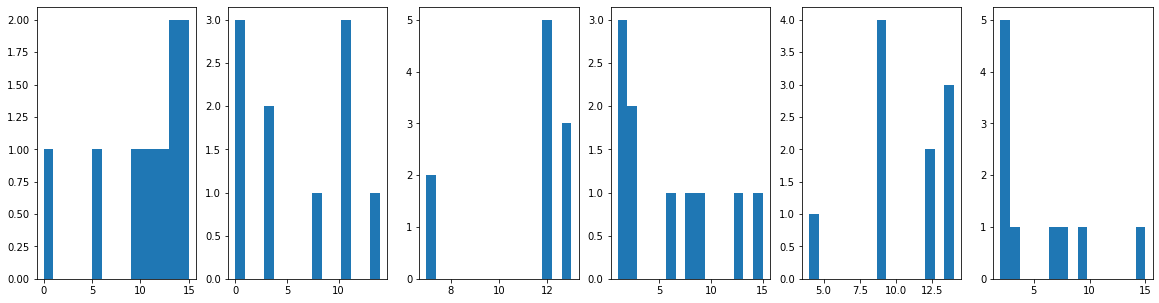

!!


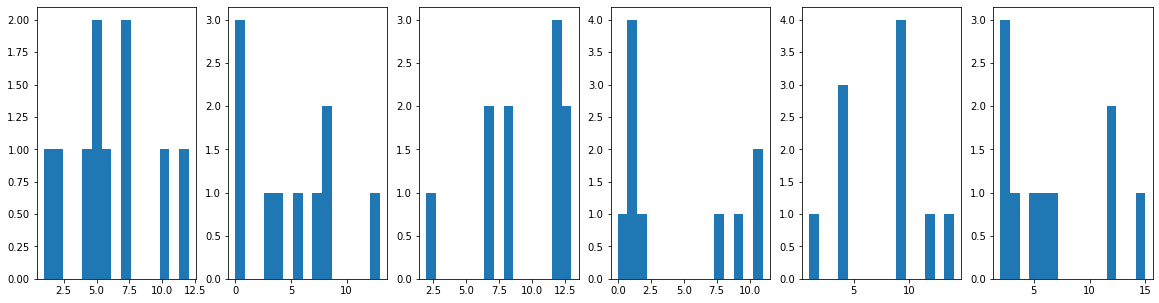

In [15]:
def visualize_generated_distribution(gen_model, z_dim, distribution_count=2_500):
        z = get_noise(distribution_count, z_dim=z_dim, device=device)
        out_v = torch.argmax(gen_model(z).view(distribution_count, 6, 16), dim=2)
        res = [[] for _ in range(6)]
        for row in out_v:
            for i in range(6):
                res[i].append(row[i].item())

        fig, plots = plt.subplots(nrows=1, ncols=6, figsize = (20,5))
        for idx in range(6):
            plots[idx].hist(res[idx], bins=15)
        plt.show()

visualize_generated_distribution(gen, z_dim, 10)
print("!!")
visualize_generated_distribution(gen, z_dim, 10)


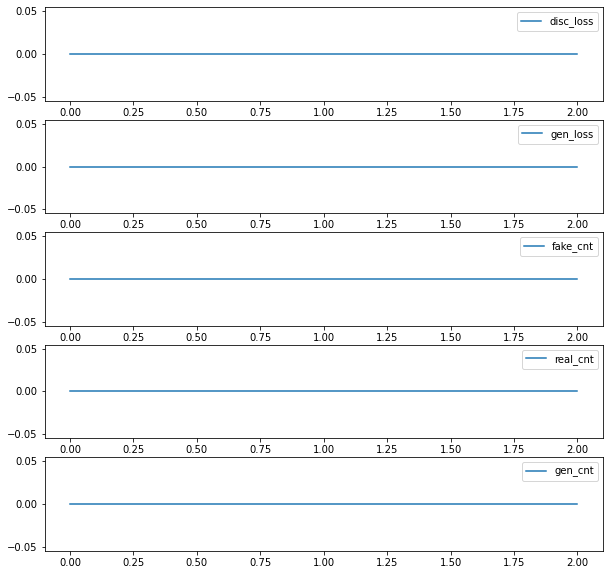

In [16]:
def visualize_epochs(data:dict):
    keys = sorted([i for i in data.keys()])
    items = ["disc_loss", "gen_loss", "fake_cnt", "real_cnt", "gen_cnt"]
    fig, plots = plt.subplots(nrows=len(items), ncols=1, figsize = (10, 10))

    for idx, measure in enumerate(items):
        values = [data[k][measure] for k in keys]
        plots[idx].plot(keys, values, label=measure)
        plots[idx].legend(loc="upper right")
    plt.show()

data = {
    0:  {
         "disc_loss": 0,
        "gen_loss": 0,
        "fake_cnt": 0,
        "real_cnt": 0,
        "gen_cnt": 0
    },
    1:  {
         "disc_loss": 0,
        "gen_loss": 0,
        "fake_cnt": 0,
        "real_cnt": 0,
        "gen_cnt": 0
    },
    2:  {
         "disc_loss": 0,
        "gen_loss": 0,
        "fake_cnt": 0,
        "real_cnt": 0,
        "gen_cnt": 0
    }
}

visualize_epochs(data)

In [17]:
def crate_thresholded_data(tensor):
    output_copy = torch.zeros_like(tensor)
    output_copy[tensor[:] <= THRESHOLD] = 0
    output_copy[tensor[:] > THRESHOLD] = 1
    return output_copy

t = torch.tensor([[0, 0.5, 0.7, 1], [0, 0.5, 0.7, 1]])
print( crate_thresholded_data(t))

tensor([[0., 0., 1., 1.],
        [0., 0., 1., 1.]])


In [18]:
def calculate_accuracy_real(gen, disc, real, num_images, z_dim, device):
    sigmoid = nn.Sigmoid().to(device)
    z = get_noise(num_images, z_dim, device=device)
    fake = gen(z)

    out_fake = crate_thresholded_data(sigmoid(disc(fake)))
    fake_cnt = torch.sum(out_fake == torch.zeros((num_images,1), device=device)).item()
    #loss_fake = criterion(out_fake, torch.zeros((num_images,1), device=device))

    out_real = crate_thresholded_data(sigmoid(disc(real)))
    real_cnt = torch.sum(out_real == torch.ones((num_images,1), device=device)).item()
    #loss_real = criterion(out_real, torch.ones((num_images,1), device=device))

    out = crate_thresholded_data(sigmoid(disc(gen(z))))
    #gen_loss = criterion(out, torch.ones((num_images,1), device=device))
    gen_cnt = torch.sum(out == torch.ones((num_images,1), device=device)).item()

    # print(fake_cnt, real_cnt, gen_cnt, out, sigmoid(disc(gen(z))))
    gen.zero_grad()
    disc.zero_grad()

    return fake_cnt, real_cnt, gen_cnt

for _, (real, _) in tqdm(dataset_loader):
    break

fake_cnt, real_cnt, gen_cnt = calculate_accuracy_real(gen, disc, real.view(real.shape[0], -1).to(device), real.shape[0], z_dim, device)


  0%|          | 0/1550 [00:00<?, ?it/s]


In [19]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    z = get_noise(num_images, z_dim, device=device)
    out = disc(gen(z))
    gen_loss = criterion(out, torch.ones((num_images,1), device=device))
    return gen_loss

In [20]:
def test_gen_reasonable(num_images=10):
    # Don't use explicit casts to cuda - use the device argument
    import inspect, re
    lines = inspect.getsource(get_gen_loss)
    assert (re.search(r"to\(.cuda.\)", lines)) is None
    assert (re.search(r"\.cuda\(\)", lines)) is None

    z_dim = 64
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 1)
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor - 1) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)


def test_gen_loss(num_images):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

    gen_loss = get_gen_loss(gen, disc, criterion, num_images, z_dim, device)

    # Check that the loss is reasonable
    assert (gen_loss - 0.7).abs() < 0.1
    gen_loss.backward()
    old_weight = gen.gen[0][0].weight.clone()
    gen_opt.step()
    new_weight = gen.gen[0][0].weight
    assert not torch.all(torch.eq(old_weight, new_weight))


#test_gen_reasonable(10)
#test_gen_loss(18)
print("Success!")

Success!


In [21]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):

    z = get_noise(num_images, z_dim, device=device)
    fake = gen(z).detach()

    out_fake = disc(fake)
    loss_fake = criterion(out_fake, torch.zeros((num_images,1), device=device))

    out_real = disc(real)
    loss_real = criterion(out_real, torch.ones((num_images,1), device=device))

    disc_loss = (loss_fake + loss_real) / 2

    return disc_loss

In [22]:
def test_disc_reasonable(num_images=10):
    # Don't use explicit casts to cuda - use the device argument
    import inspect, re
    lines = inspect.getsource(get_disc_loss)
    assert (re.search(r"to\(.cuda.\)", lines)) is None
    assert (re.search(r"\.cuda\(\)", lines)) is None

    z_dim = 64
    gen = torch.zeros_like
    disc = lambda x: x.mean(1)[:, None]
    criterion = torch.mul # Multiply
    real = torch.ones(num_images, z_dim)
    disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(disc_loss.mean() - 0.5) < 1e-5)

    gen = torch.ones_like
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, z_dim)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu')) < 1e-5)

    gen = lambda x: torch.ones(num_images, 10)
    disc = lambda x: x.mean(1)[:, None] + 10
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 10)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu').mean() - 5) < 1e-5)

    gen = torch.ones_like
    disc = nn.Linear(64, 1, bias=False)
    real = torch.ones(num_images, 64) * 0.5
    disc.weight.data = torch.ones_like(disc.weight.data) * 0.5
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    criterion = lambda x, y: torch.sum(x) + torch.sum(y)
    disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu').mean()
    disc_loss.backward()
    assert torch.isclose(torch.abs(disc.weight.grad.mean() - 11.25), torch.tensor(3.75))

def test_disc_loss(max_tests = 10):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    num_steps = 0
    for _, (real, real_noise) in dataset_loader:
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradient before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        assert (disc_loss - 0.68).abs() < 0.05

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Check that they detached correctly
        assert gen.gen[0][0].weight.grad is None

        # Update optimizer
        old_weight = disc.disc[0][0].weight.data.clone()
        disc_opt.step()
        new_weight = disc.disc[0][0].weight.data

        # Check that some discriminator weights changed
        assert not torch.all(torch.eq(old_weight, new_weight))
        num_steps += 1
        if num_steps >= max_tests:
            break

#test_disc_reasonable()
#test_disc_loss()
print("Success!")

Success!


In [23]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
error = False
cur_epoches = 1

In [24]:
train_losses = {}


100%|██████████| 1550/1550 [01:15<00:00, 20.43it/s, epoch=10]


10


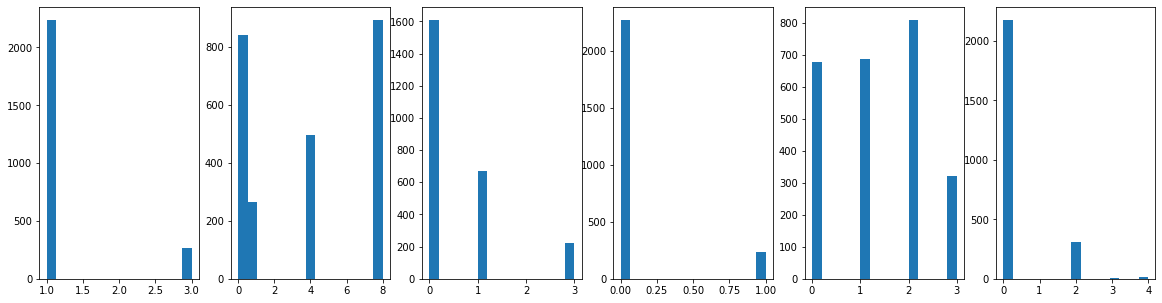

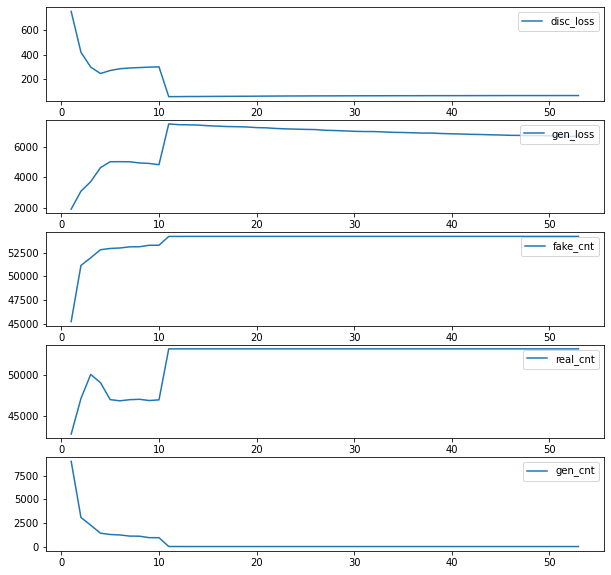

100%|██████████| 1550/1550 [01:15<00:00, 20.62it/s, epoch=20]


20


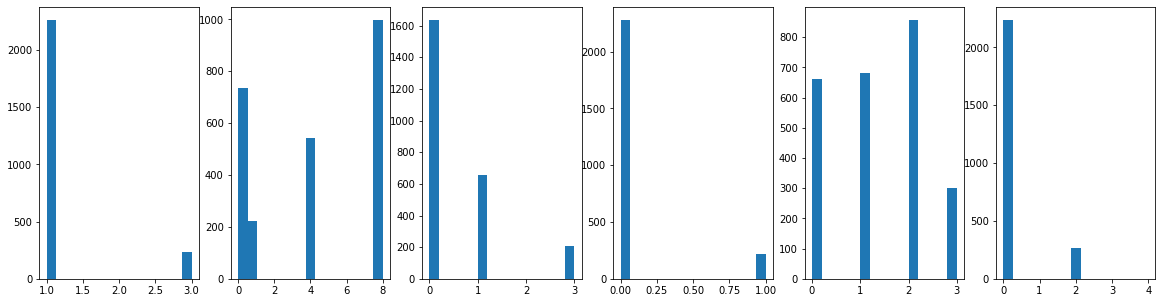

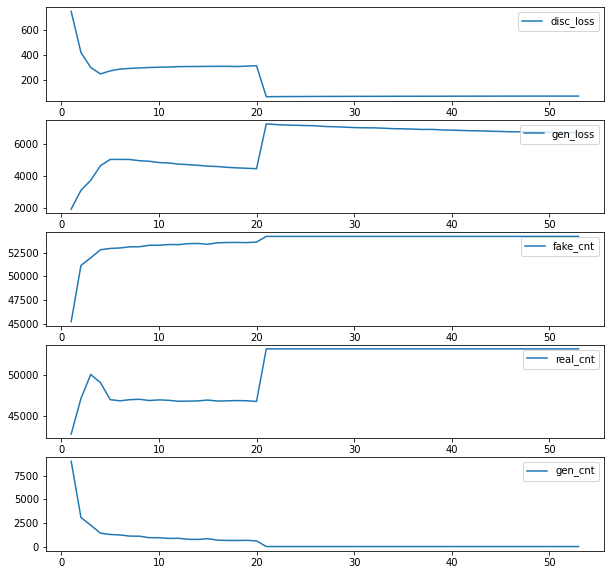

100%|██████████| 1550/1550 [01:15<00:00, 20.61it/s, epoch=30]


30


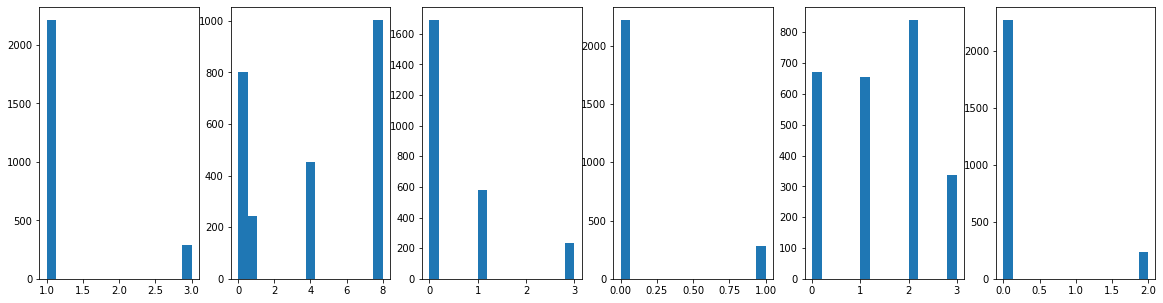

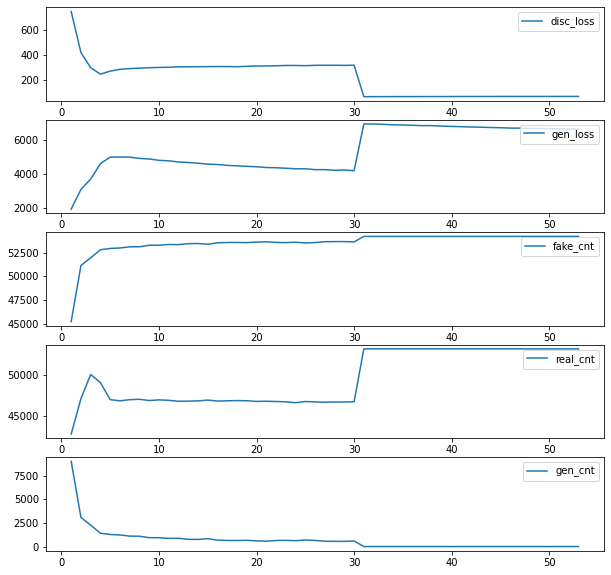

100%|██████████| 1550/1550 [01:15<00:00, 20.44it/s, epoch=40]


40


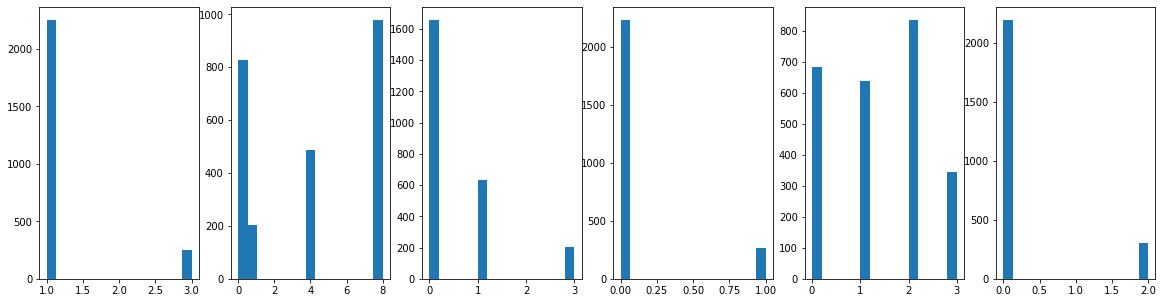

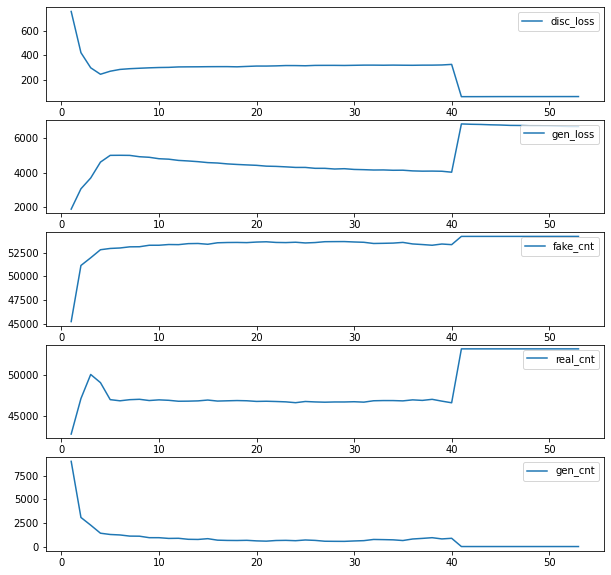

100%|██████████| 1550/1550 [01:18<00:00, 19.85it/s, epoch=50]


50


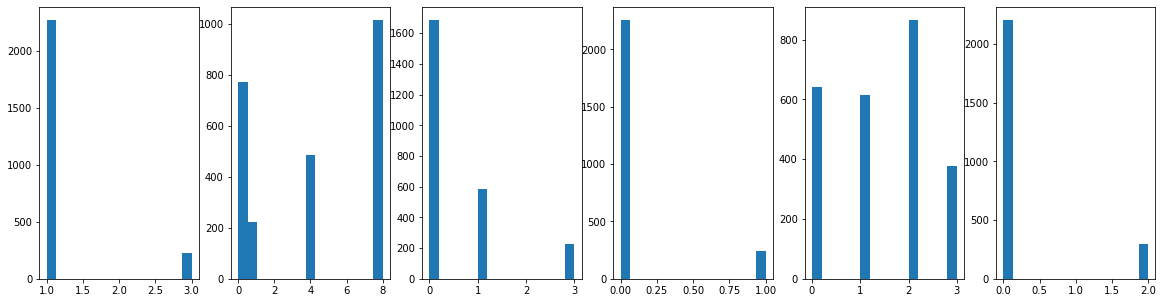

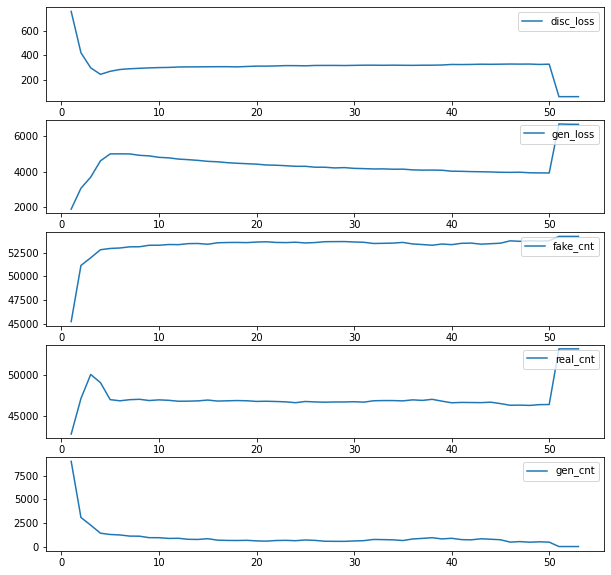

100%|██████████| 1550/1550 [01:15<00:00, 20.54it/s, epoch=60]


60


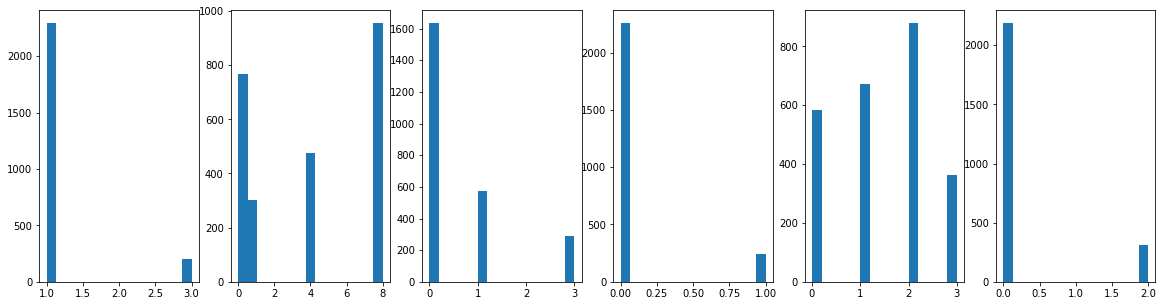

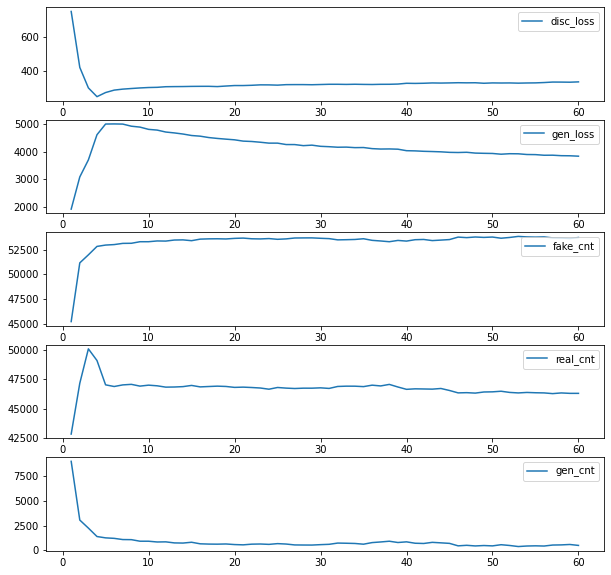

100%|██████████| 1550/1550 [01:15<00:00, 20.51it/s, epoch=70]


70


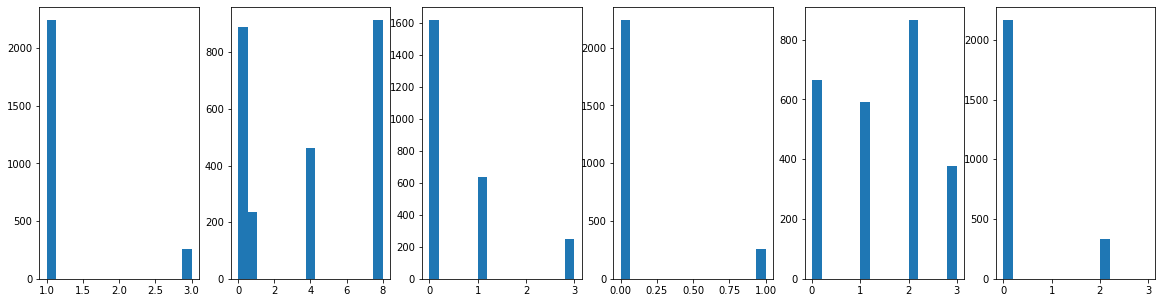

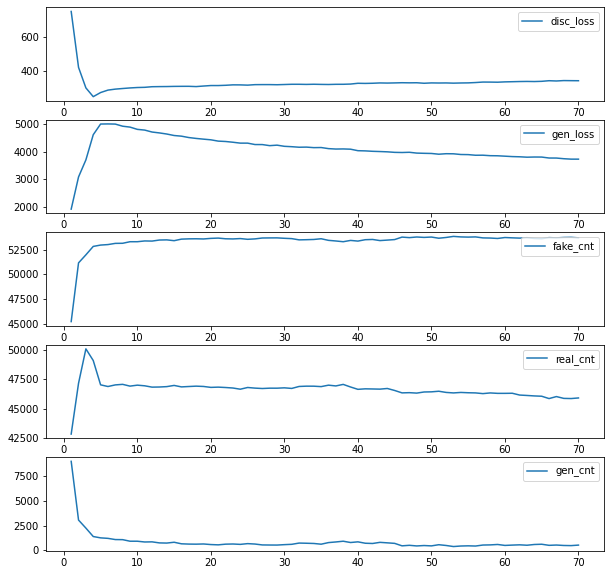

100%|██████████| 1550/1550 [01:15<00:00, 20.50it/s, epoch=80]


80


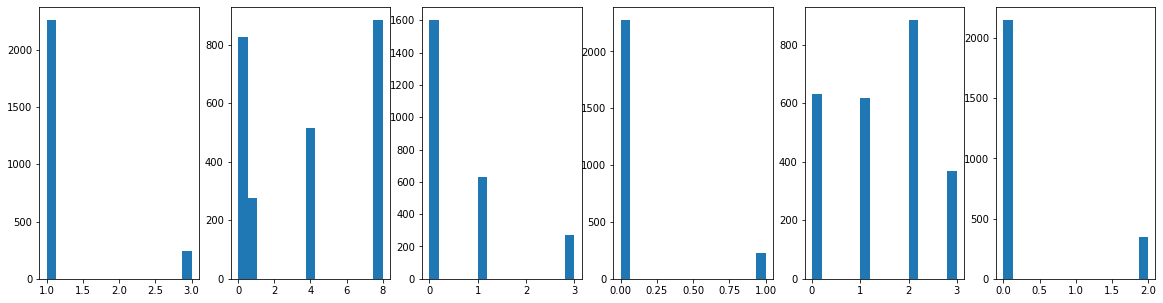

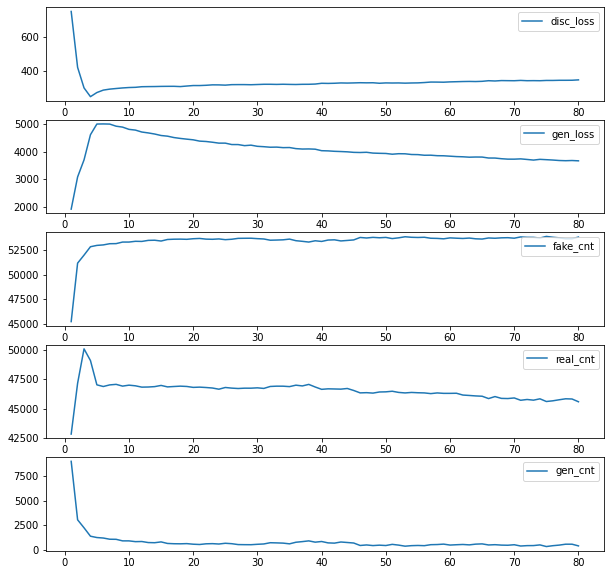

100%|██████████| 1550/1550 [01:16<00:00, 20.26it/s, epoch=90]


90


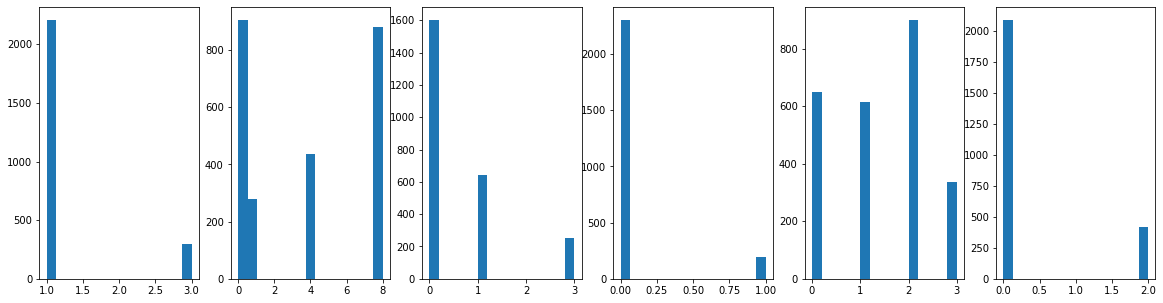

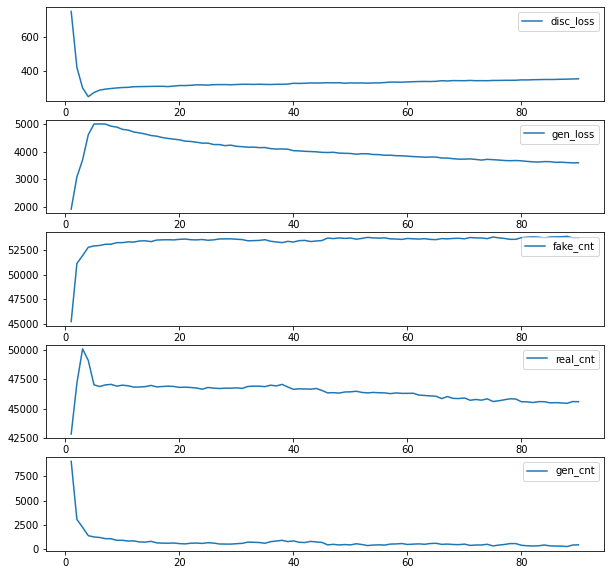

100%|██████████| 1550/1550 [01:17<00:00, 19.88it/s, epoch=100]


100


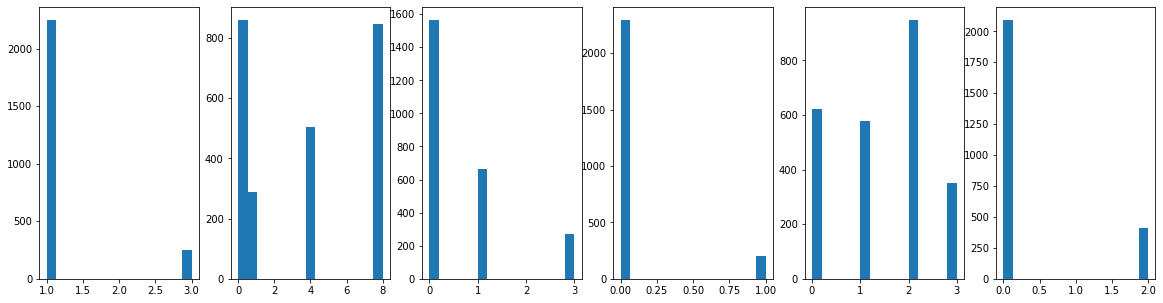

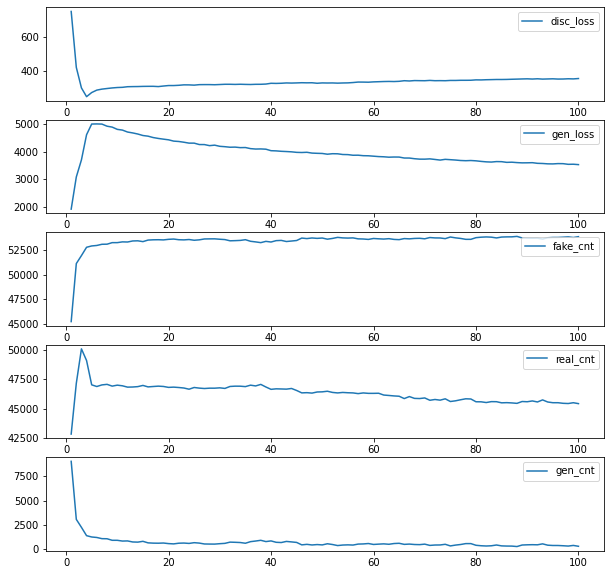

100%|██████████| 1550/1550 [01:15<00:00, 20.64it/s, epoch=110]


110


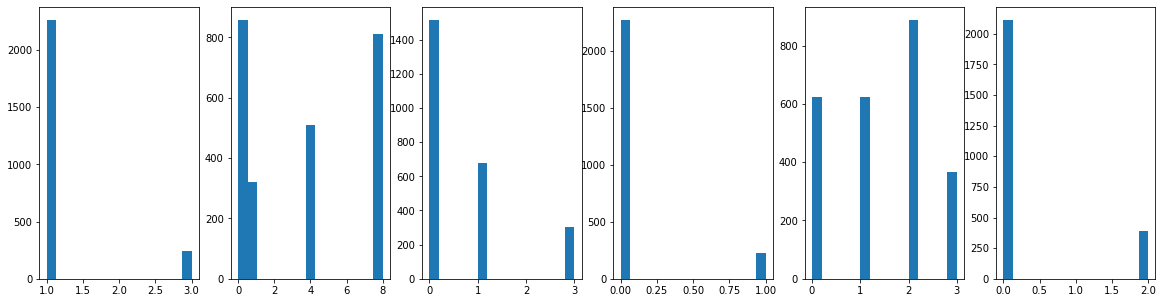

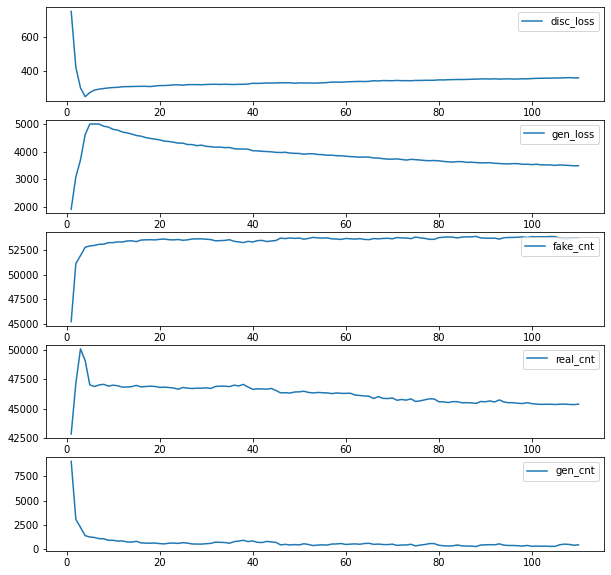

100%|██████████| 1550/1550 [01:15<00:00, 20.54it/s, epoch=120]


120


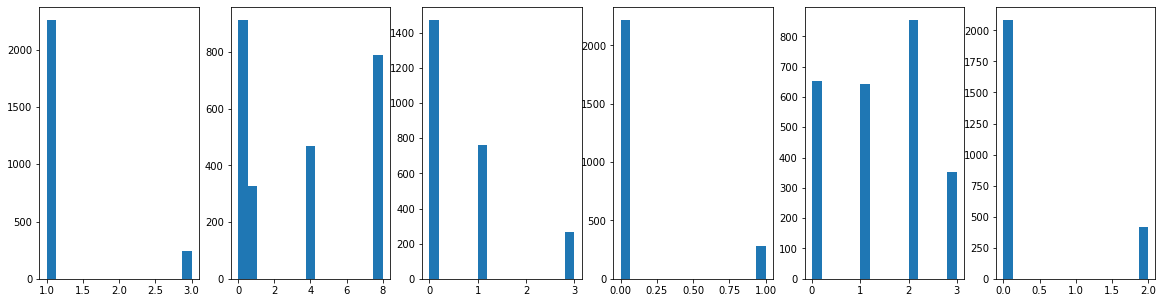

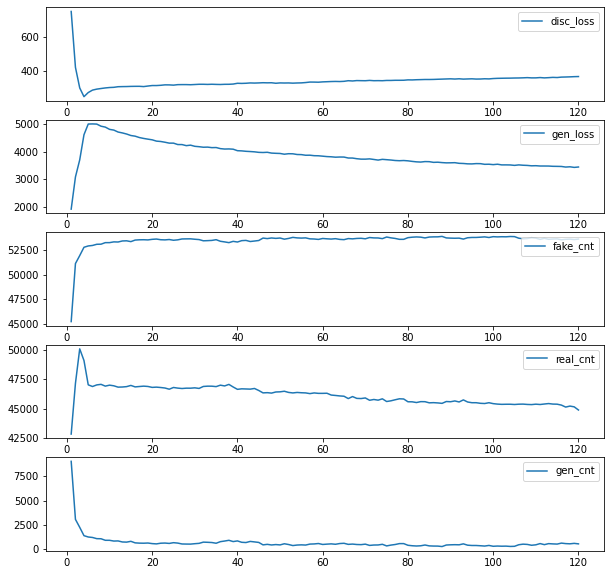

100%|██████████| 1550/1550 [01:15<00:00, 20.46it/s, epoch=130]


130


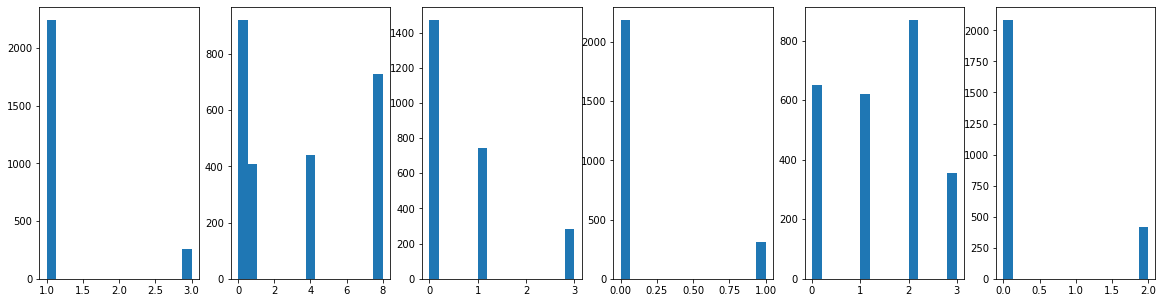

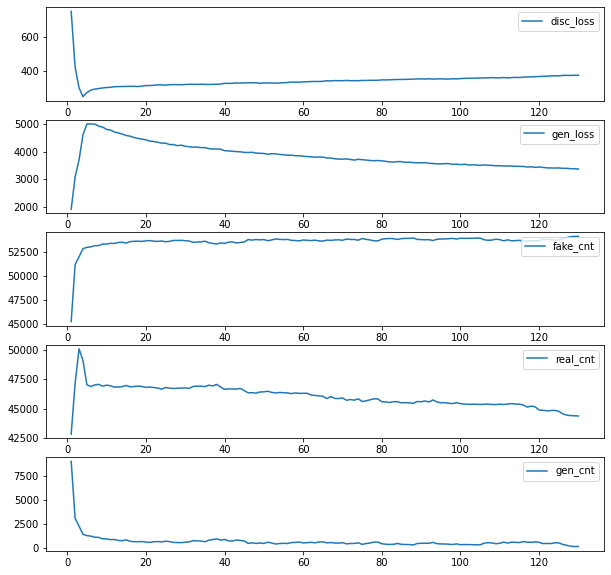

100%|██████████| 1550/1550 [01:15<00:00, 20.50it/s, epoch=140]


140


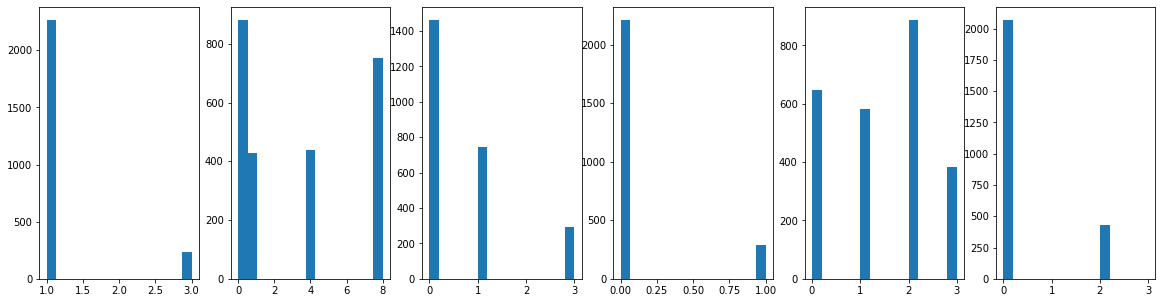

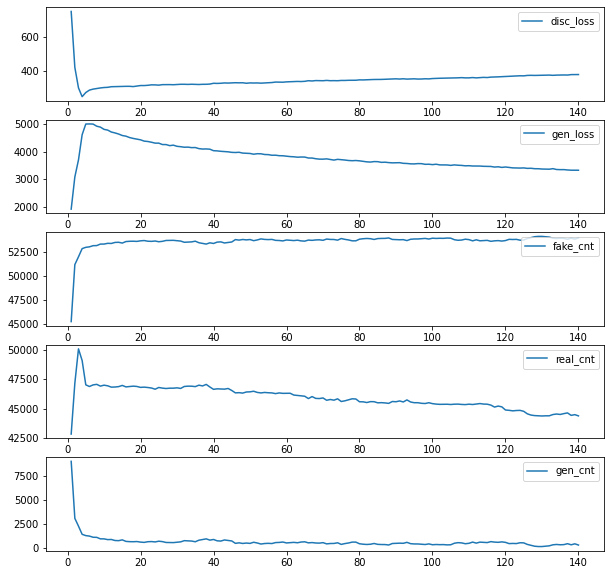

 26%|██▋       | 410/1550 [00:20<00:54, 20.79it/s, epoch=143]

In [ ]:
for epoch in range(cur_epoches, n_epochs):

    disc_train_loss = 0
    gen_train_loss = 0
    fake_cnt = 0
    real_cnt = 0
    gen_cnt = 0

    size = 0
    tqdm_loader = tqdm(dataset_loader)

    for _, (real, _) in tqdm_loader:
        cur_batch_size = real.shape[0]
        #print(cur_batch_size)
        real = real.view(cur_batch_size, -1).to(device)
        #print(real.shape)

        size += cur_batch_size

        disc_opt.zero_grad()
        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, num_images=cur_batch_size, z_dim=z_dim, device=device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        if not test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")


        z = get_noise(2, z_dim, device=device)
        out = gen(z)
        out_v = torch.argmax(out.view(2, 6, 16), dim=2)
        #print(out_v.shape, out_v)
        disc_train_loss += disc_loss.item()
        gen_train_loss += gen_loss.item()

        fake_cnt_ep, real_cnt_ep, gen_cnt_ep = calculate_accuracy_real(gen, disc, real, cur_batch_size, z_dim, device)
        fake_cnt += fake_cnt_ep
        real_cnt += real_cnt_ep
        gen_cnt += gen_cnt_ep
        tqdm_loader.set_postfix(epoch=epoch)

    train_losses[epoch] = {
        "disc_loss": disc_train_loss,
        "gen_loss": gen_train_loss,
        "fake_cnt": fake_cnt,
        "real_cnt": real_cnt,
        "gen_cnt": gen_cnt
    }
    
    if epoch % 10 == 0:
        print(epoch)
        visualize_generated_distribution(gen, z_dim, 2_500)
        visualize_epochs(train_losses)